In [1]:
import sys
sys.path.append("../lib/")
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_validation_curve,
                                     plot_roc_comparison,
                                     boxplot_comparison)


2023-08-12 13:57:58.775209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10

In [24]:
dataset = "L_540_2022_CERB"
img_path = Path("../img/") / dataset
img_path.mkdir(parents=True, exist_ok=True)
results_path = Path("../results/") / dataset
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))
if "file" in data.columns:
    X = data.drop(columns=["label", "file"])    
else:
    X = data.drop(columns=[""])
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)
y = pd.factorize(data.label)[0]
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
# Define model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2), 
    Dense(64, activation='relu'),
    Dropout(0.2),   
    Dense(y_train.shape[1], activation='softmax')
])
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=150, batch_size=64, 
    verbose=False, #callbacks=[EarlyStopping(patience=500, restore_best_weights=True)]
                   )
# Evaluate model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
#history.evaluate()

10/10 - 0s - loss: 1.2345 - accuracy: 0.6467 - 43ms/epoch - 4ms/step
Test loss: 1.2344719171524048
Test accuracy: 0.6466666460037231


10/10 [==============================] - 0s 2ms/step


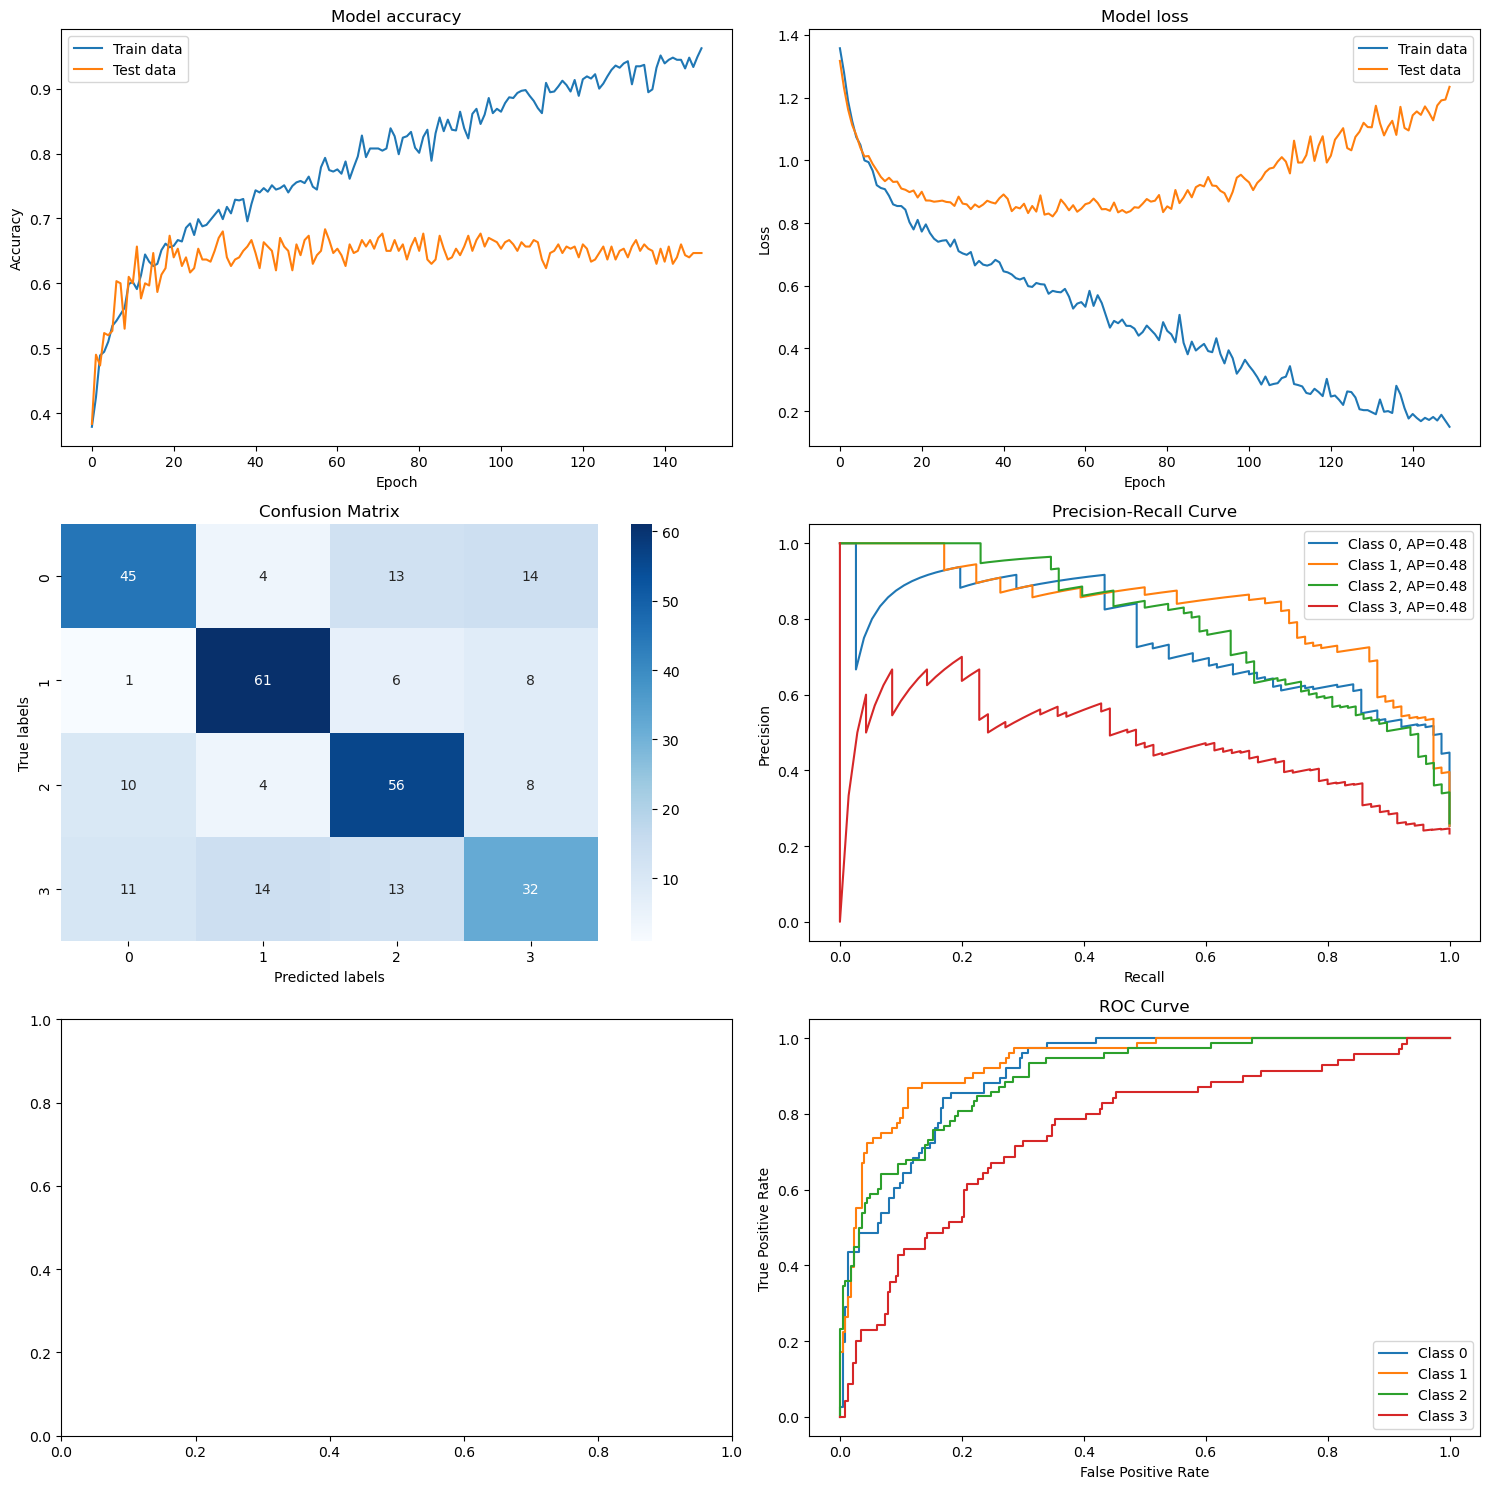

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Plot accuracy values
ax[0, 0].plot(history.history['accuracy'], label='Train data')
ax[0, 0].plot(history.history['val_accuracy'], label='Test data')
ax[0, 0].set_title('Model accuracy')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].legend()

# Plot loss values
ax[0, 1].plot(history.history['loss'], label='Train data')
ax[0, 1].plot(history.history['val_loss'], label='Test data')
ax[0, 1].set_title('Model loss')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].legend()

# Confusion Matrix
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax[1, 0])
ax[1, 0].set_xlabel('Predicted labels')
ax[1, 0].set_ylabel('True labels')
ax[1, 0].set_title('Confusion Matrix')

# Precision-Recall Curve
y_probs = model.predict(X_test)
n_classes = y_probs.shape[1]
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_probs[:, i])
    ax[1, 1].plot(recall, precision, label=f'Class {i}, AP={avg_precision:0.2f}')
ax[1, 1].set_xlabel('Recall')
ax[1, 1].set_ylabel('Precision')
ax[1, 1].set_title('Precision-Recall Curve')
ax[1, 1].legend()

# ROC Curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_probs[:, i])
    ax[2, 1].plot(fpr, tpr, label=f'Class {i}, AUC={roc_auc:.2f}')
ax[2, 1].set_xlabel('False Positive Rate')
ax[2, 1].set_ylabel('True Positive Rate')
ax[2, 1].set_title('ROC Curve')
ax[2, 1].legend()

plt.tight_layout()
plt.show()


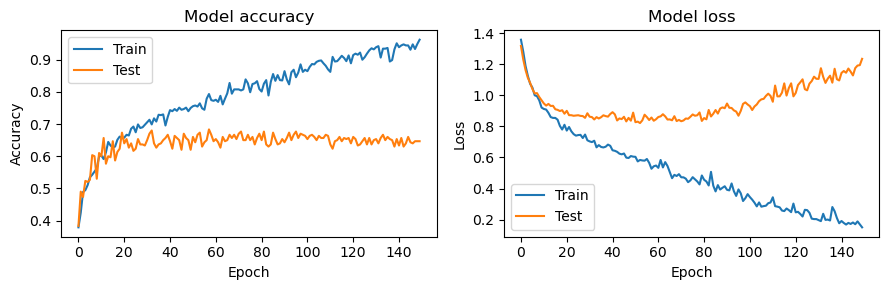

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
# Plot accuracy values
ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Test')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()
# Plot loss values
ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Test')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()
# Show the plots
plt.tight_layout() 

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Augmentation

In [ ]:
def augment_data(X, y, num_augmentations=2, noise_scale=0.015, scale_range=(0.9, 1.1), shift_range=(-20, 20)):
    X_augmented = []
    y_augmented = []
    
    for xi, yi in zip(X, y):
        for _ in range(num_augmentations):
            X_augmented.append(xi)
            y_augmented.append(yi)

            xi_noisy = xi + np.random.normal(0, noise_scale, xi.shape)
            X_augmented.append(xi_noisy)
            y_augmented.append(yi)

            xi_scaled = np.random.uniform(*scale_range)
            xi_scaled *= xi
            X_augmented.append(xi_scaled)
            y_augmented.append(yi)

            xi_shift = np.roll(xi, shift=int(np.random.uniform(*shift_range)))
            X_augmented.append(xi_shift)
            y_augmented.append(yi)
        
    return np.array(X_augmented), np.array(y_augmented)

# Call the function on your data
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

#print(X_train.shape)
#print(X_train_augmented.shape)

In [ ]:
# Define model
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(y_one_hot.shape[1], activation='softmax')  # Number of output neurons equals number of classes in dataset
])

In [ ]:
# Compile model with costom learning rate, default 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Set up early stopping callback
early_stopping = EarlyStopping(patience=500)
# Train == fit model
history_aug = model.fit(
    X_train_augmented, y_train_augmented, 
    validation_data=(X_test, y_test),
    epochs=1000, 
    batch_size=32, 
    verbose=False, 
    callbacks=[early_stopping]
)
# Evaluate model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2) # verbose2 for clear output
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

In [ ]:
plt.figure(figsize=(12,5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()